# Figure 2 - radii

This figure shows the radii used to compute the surrounding land cover at each recording location. This example shows the land cover surrounding location 15, which is at the edge of an inner-city park. 

#### import statements

In [1]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import lines
from matplotlib.colors import LinearSegmentedColormap

import pandas
import numpy
import geopandas
import pyproj
from shapely.geometry import shape

from os import path

from django.db import connection
from database.models import Site
from landscape.models import LandCoverTypeMap

from figutils import query, style

#### variable definitions

figure directory

In [2]:
figure_directory = ""

recording location (site)

In [3]:
site = Site.objects.get(name="Hofgarten")

#### coordinate systems

In [4]:
austria_mgd = pyproj.Proj(init='epsg:31254')

#### formating

In [5]:
style.set_font()

#### query data

In [6]:
# get land cover around the specified recording location (site)
modification = 'SELECT "landscape_landcover"."id", "landscape_landcover"."cover_type", ST_Intersection("landscape_landcover"."geometry", %s) AS "geometry" FROM "landscape_landcover" WHERE ST_Intersects("landscape_landcover"."geometry", %s)'
point_landcover = query.get_geodataframe(query.get_landcover(site.geometry, radius = 600), 
                                         modification=modification)

# define radii in a geodataframe
radii = geopandas.GeoDataFrame([{'name': '50m', 'geometry': shape(eval(site.geometry.buffer(50).geojson))},
                                {'name': '100m', 'geometry': shape(eval(site.geometry.buffer(100).geojson))},
                                {'name': '200m', 'geometry': shape(eval(site.geometry.buffer(200).geojson))},
                                {'name': '500m', 'geometry': shape(eval(site.geometry.buffer(500).geojson))},], 
                               index=numpy.arange(4), crs=austria_mgd, geometry='geometry')

# define land cover colormap
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]
landcover_colormap = LinearSegmentedColormap.from_list(name='landcover', colors=color_list)

#### plot

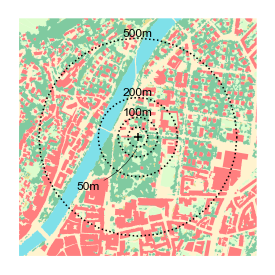

In [7]:
# create figure
figure2, ax = pyplot.subplots()
figure2.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
figure2.set_figheight(3.30)
figure2.set_figwidth(3.30)

# plot land cover
p1 = point_landcover.plot(ax=ax, vmax=15, column='cover_type', edgecolor='none', cmap=landcover_colormap, alpha=0.5)

# plot radii
p2 = radii.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, linestyle=':')

# plot recording location (site)
p3 = ax.scatter(site.geometry.coords[0], site.geometry.coords[1], marker='+', s=75, color='black', linewidths=1, alpha=1)

# set plot extent
bbox = numpy.array(site.geometry.buffer(600).envelope.coords[0])
ax.set_xlim([bbox[:, 0].min(), bbox[:, 0].max()])
ax.set_ylim([bbox[:, 1].min(), bbox[:, 1].max()])

# format plot
ax.set_frame_on(False)
ax.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ap = dict(arrowstyle='-', connectionstyle='arc3,rad=0.2', linewidth=0.5)

# label radii
x = site.geometry.coords[0]
y = site.geometry.coords[1]
a1 = ax.annotate('50m', (x+0, y+-50), xytext=(x-250, y-250), ha='center', va='center', size=12, arrowprops=ap)
a2 = ax.annotate('100m', (x+0, y+100), xytext=(x+0, y+125), ha='center', va='center', size=12, arrowprops=ap)
a3 = ax.annotate('200m', (x+0, y+200), xytext=(x+0, y+225), ha='center', va='center', size=12)
a4 = ax.annotate('500m', (x+0, y+500), xytext=(x+0, y+525), ha='center', va='center', size=12)

# add scalebar
#fp = FontProperties(size=12)
#scale_bar = scalebars.add_scalebar(ax, matchx=False, matchy=False,
#                         labely=None, sizey=None, labelx='500 meters', sizex=500, loc=3, prop=fp)

#### save figure

In [8]:
#figure2.savefig(path.join(figure_directory, "figure2.png"), dpi=1200)